# Project 2

# Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [1]:
%matplotlib inline
import pandas as pd

In [2]:
data = pd.read_csv("dataTrain_carListings.csv")

In [3]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [4]:
data.shape

(500000, 6)

In [5]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

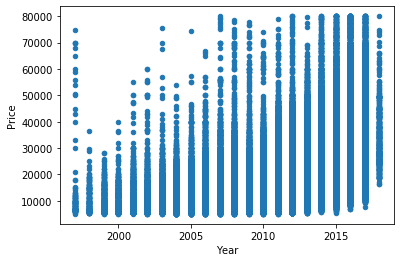

In [6]:
data.plot(kind='scatter', y='Price', x='Year')

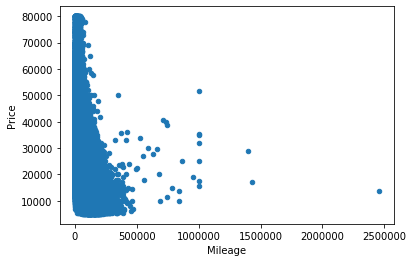

In [7]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [8]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

# Exercise P2.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the model using K-Fold (K=10) cross-validation
- 25% - Notebook explaining the modeling process


### Librerias

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
import math as math

### Edición de datos

Dado que se tienen numerosas categorias de naturaleza string, se procede a realizar un diccionario, en donde a cada refrencia de estad, marca y modelo se le asigna un un número que a su vez se considera como una varaible categorica. de esta manera el modelo podra leer estas columnas que originalmente venian en texto.

In [18]:
#Generación de categóricas

estado = pd.DataFrame( data.State.unique() ) 
marca =  pd.DataFrame(   data.Make.unique() )
Modelo = pd. DataFrame(data.Model.unique())

estado["Statek"] = estado.index 
marca["marcak"] = marca.index
Modelo["modelok"] = Modelo.index 

estado.columns =["State" , "State1"] 
marca.columns =["Make" , "Make1"] 
Modelo.columns =["Model" , "Model1"] 

#modificar los datos 

data2 = data.merge(estado, on= "State", how='left')
data2 = data2.merge(marca, on= "Make", how='left')
data2 = data2.merge(Modelo, on= "Model", how='left')

data2  = data2.loc[:, ["Price" , "Year" , "Mileage" , "State1" , "Make1" ,"Model1"]]
 
data2.State1 = pd.Categorical(data2.State1)
data2.Make1 = pd.Categorical(data2.Make1)
data2.Model1 = pd.Categorical(data2.Model1)

data2.head()

,Price,Year,Mileage,State1,Make1,Model1
0,21490,2014,31909,0,0,0
1,21250,2016,25741,1,1,1
2,20925,2016,24633,2,2,2
3,14500,2012,84026,3,3,3
4,32488,2013,22816,4,3,4


In [19]:
data2.Price.mean()

21144.186304

In [20]:
estado.to_csv("estado.csv")
marca.to_csv("marca.csv")
Modelo.to_csv("modelo.csv")

### Train y Test

In [21]:
Data_train, Data_test = train_test_split(data2, test_size=0.3, random_state=42)

In [22]:
Data_train.head()

,Price,Year,Mileage,State1,Make1,Model1
226114,26990,2017,12430,4,5,89
435187,12995,2010,76254,10,14,102
294452,19629,2014,59097,13,10,241
427864,10800,2014,109175,9,1,121
188822,25999,2015,24840,27,10,227


In [23]:
Data_test.head()

,Price,Year,Mileage,State1,Make1,Model1
104241,18231,2017,30223,13,5,260
199676,22982,2015,12764,22,1,121
140199,16219,2017,37951,0,4,73
132814,21995,2016,80649,29,15,166
408697,17995,2014,24579,8,11,77


## Random Forest Regressor

El primer modelo que se prueba es la realización de un randomforest con el fin de dar una primera aproximación al desempeño del pronostico, la medida de desemeño utilizada para la comparación es la media del error cuadratico medio para un CV de 10 

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score

In [10]:
reg = RandomForestRegressor()

In [136]:
X = Data_train.iloc[:,1:]
y = Data_train.iloc[:,0]
reg.fit(X, y)

C:\Users\IVAN\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [137]:
X_test = Data_test.iloc[:,1:]
y_test = Data_test.iloc[:,0]
math.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

3961.0266271553273

La primera aproximación del pronostico brinda una raiz de error medio de 3961 usd, este valor inicia como punto de referencia para poder encontrar un mejor modelo.

### Random Forest Regressor Tunning

## Cross-validation

Creación de k-folds para cross-validation y tunning de parametros.

In [103]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = Data_train.shape[0]
n_B = 10
print(n_samples)

350000


In [104]:
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=int(n_samples*0.1) , replace=False) for _ in range(1, n_B +1 )]
samples

[array([171019, 102195,  89844, ...,   4690,  53624, 310462]),
 array([ 25493, 340961, 235729, ..., 113814, 254940, 275959]),
 array([ 17356,  47142, 280753, ..., 215843,  92175, 252405]),
 array([182810,   1064, 202009, ..., 137333, 205232, 256836]),
 array([255518,   7849, 289096, ..., 210963,  64924,  65650]),
 array([156722, 200348, 169264, ..., 249600, 197775,  55558]),
 array([ 95576, 269254, 255375, ..., 200203, 262233, 307033]),
 array([ 84463, 115951,  34767, ..., 161027, 315553, 256996]),
 array([183504,   6808, 193542, ..., 154581, 140276, 125598]),
 array([339313, 195651, 263726, ...,  43687, 249328, 178922])]

### Características

Elección del mejor estimador para random forest.Como primera iteración se busca calibrar el parametro n_estimators el cual se utiliza como el número de arboles que son utilizados en cada iteración con el fin de calibrar el modelo, con un mayor número de stimadores el modelo se vuelve mas robusto al poderse complementar facilmente abarcando muchas mas posibles sets de datos, logrando un mejor aprendizaje. Se procede a mover este valor de 10 en 10 hasta un maximo de 100 estimadores en el modelo.

In [147]:

np.random.seed(123)

n_samples = data2.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=int(n_samples*0.3) , replace=False) for _ in range(1, n_B +1 )]

estimator_range = range(10, 100, 10)

mse_score =[] 
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    for sample in range(10):
        Data_train = data2.drop(samples[sample], axis=0)
        Data_test = data2.iloc[samples[sample],:]
        
        X = Data_train.iloc[:,1:]
        y = Data_train.iloc[:,0]
        reg.fit( X , y)
        y_pred = reg.predict(Data_test.iloc[:,1:])
        mse_score.append(math.sqrt(mean_squared_error(Data_test.iloc[:,0].values,y_pred)))  
mse_score

[3924.521540630205,
 3940.1807001378165,
 3950.2420322600215,
 3918.9410720146116,
 3938.3111176036427,
 3919.7305392480866,
 3962.782742197445,
 3919.1293597754266,
 3923.278200311982,
 3908.7425482477097,
 3858.3248522007652,
 3864.832118800209,
 3881.0825394753124,
 3849.4274614353503,
 3870.2665963408535,
 3850.4407333411377,
 3886.935696841622,
 3850.597647775031,
 3851.5325978483943,
 3838.116452141276,
 3838.8358072044252,
 3841.3850325700305,
 3853.83686682001,
 3825.8946593655764,
 3847.2175082792623,
 3827.8138050912235,
 3866.2533293526153,
 3829.296102109187,
 3828.7261157794383,
 3815.989611725299,
 3826.1181335652886,
 3831.6403119022893,
 3839.7702438988367,
 3816.20623193372,
 3833.4678101769346,
 3818.264073120483,
 3855.6432215266377,
 3816.0676957951687,
 3815.424457547991,
 3803.211162572432,
 3818.1210878820107,
 3824.578432589633,
 3831.804784445944,
 3811.786185271668,
 3824.5759638068985,
 3811.9506359201896,
 3847.9596223546105,
 3810.0082510043103,
 3811.18525

In [164]:
mse_grp = np.array_split(mse_score, 9)

In [165]:
rmse = []
for t in range(len(mse_grp)):
    rmse.append( np.mean(mse_grp[t]))
rmse

[3930.5859852426947,
 3860.155669619996,
 3837.524883829707,
 3825.581334203978,
 3818.5857611800516,
 3813.6537051885416,
 3810.229937219716,
 3808.0163193360704,
 3806.3573588663553]

Como se puede observar, a medida que el número de estimadores aumenta, el error va disminuyendo, llegando a un nivel donde la disminución resulta marginal posterior a los 60 estimadores, donde la ganancia es baja comparativa con el costo operacional de incrementar el número de estimadores.

### MSE

Text(0, 0.5, 'RMSE')

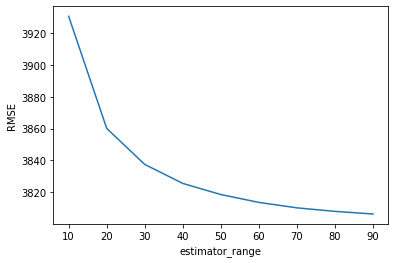

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt 

# plot estimator_range (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, rmse)
plt.xlabel('estimator_range')
plt.ylabel('RMSE')

En la grafica se observa de una mejor manera la convergencia del error luego de los 60 estimadores y de igual forma  el modelo empieza a presentar una mejora con respecto a la primera aproximación sin calibrar. Se procede a seguir con los demas parametros del random forest

Elección del mejor número de features para random forest.
En este caso se busca realziar la iteración del número de variables que se van a incluir como maximo en cada arbol del random forest. La aleatorización de la selección de variables busca la mejora del perfromance del modelo al incluir una mayor flexibilidad y buscando sinergias entre la variables que puede no darsen si las varaibles siemrpe son las mismas, de esta manera se busca en las iteraciones evaluar desde un número de variables de 1 hasta el maximo de varaibles disponibles que es 5.

In [171]:
feature_cols = data2.columns
feature_cols = feature_cols[1:]
feature_cols
feature_range = range(1, len(feature_cols)+1)

mse_score_f =[] 
for feature in feature_range:
    reg = RandomForestRegressor(n_estimators=100, max_features=feature, random_state=1, n_jobs=-1)
    for sample in range(10):
        Data_train = data2.drop(samples[sample], axis=0)
        Data_test = data2.iloc[samples[sample],:]
        
        X = Data_train.iloc[:,1:]
        y = Data_train.iloc[:,0]
        reg.fit( X , y)
        y_pred = reg.predict(Data_test.iloc[:,1:])
        mse_score_f.append(math.sqrt(mean_squared_error(Data_test.iloc[:,0].values,y_pred)))  
mse_score_f

[4610.2672676061275,
 4558.609861047434,
 4612.6088497181,
 4564.873864532434,
 4642.213232676843,
 4558.246032806965,
 4633.496904029002,
 4614.065304985241,
 4582.736677673638,
 4593.970390076965,
 4013.215899409892,
 3996.7942494654353,
 4014.0160676941446,
 3990.2766116693047,
 3990.0924116213323,
 3991.3931630232264,
 4031.272826881117,
 3984.719128541243,
 3990.240369295998,
 3983.791716465276,
 3834.8555946844444,
 3836.0689658116607,
 3846.216705223981,
 3825.1538304136384,
 3834.849645074071,
 3819.9099048637863,
 3860.3586283109266,
 3827.777731584771,
 3823.461602789318,
 3807.6021049208284,
 3786.8626873778494,
 3799.646407039974,
 3810.978211821296,
 3782.886286943136,
 3794.128349933103,
 3774.8524829509856,
 3820.7726566236133,
 3781.113661725109,
 3784.7582682098696,
 3767.1426918125167,
 3803.999048291874,
 3811.361917685537,
 3822.267441191564,
 3797.3450345054753,
 3808.8085009566767,
 3794.383689392031,
 3835.3216444902714,
 3795.2709838917144,
 3798.648516296635,
 

In [ ]:
mse_score_f_grp = np.array_split(mse_score, 5)

In [173]:
rmse_f = []
for t in range(len(mse_score_f_grp)):
    rmse_f.append( np.mean(mse_score_f_grp[t]))
rmse_f

[3900.987083257625,
 3835.0202607157935,
 3819.127390555768,
 3810.7231337710673,
 3806.74821763703]

Text(0, 0.5, 'RMSE')

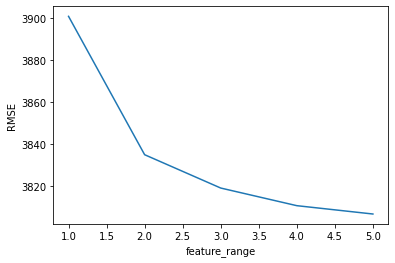

In [174]:
%matplotlib inline
import matplotlib.pyplot as plt 

# plot estimator_range (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, rmse_f)
plt.xlabel('feature_range')
plt.ylabel('RMSE')

numevamente se evidencia que el modelo presenta una mejora importante a medida que se ingresan mas variables en la aleatorización se consigue un mejor desempeño, el modelo repsenta un error de  3806 dolares como la media de la raiz de error medio en cross validation.

### Modelo

In [28]:
Data_train, Data_test = train_test_split(data2, test_size=0.3, random_state=5)

X = Data_train.iloc[:,1:]
y = Data_train.iloc[:,0]

modelo_final = RandomForestRegressor(n_estimators=60, max_features=4, random_state=1, n_jobs=-1)
modelo_final.fit( X , y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
                      oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [29]:
X_test = Data_test.iloc[:,1:]
y_test = Data_test.iloc[:,0]
y_pred = modelo_final.predict(X_test)
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))

RMSE:  3774.22857721688


### Adaboost Model

Se prueban  otros tipos de ensambles, el primero de estos es adaboost, buscando que de forma iterativa, a partir de modelos debiles se consiga un mejor MSE, se inicia tambien ajustando el maximo nùmero de estimadores del modelo.

In [25]:

np.random.seed(123)

n_samples = data2.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=int(n_samples*0.3) , replace=False) for _ in range(1, n_B +1 )]

estimator_range = range(10, 100, 10)

mse_score_ad =[] 
for estimator in estimator_range:
    reg = AdaBoostRegressor(n_estimators=estimator, random_state=1 , learning_rate = 0.1)
    for sample in range(10):
        Data_train = data2.drop(samples[sample], axis=0)
        Data_test = data2.iloc[samples[sample],:]
        
        X = Data_train.iloc[:,1:]
        y = Data_train.iloc[:,0]
        reg.fit( X , y)
        y_pred = reg.predict(Data_test.iloc[:,1:])
        mse_score_ad.append(math.sqrt(mean_squared_error(Data_test.iloc[:,0].values,y_pred)))  
mse_score_ad

[8656.68203784545,
 8658.35233322067,
 8703.556277514237,
 8676.378528087596,
 8691.439024259105,
 8676.612149388275,
 8735.245409918469,
 8672.368471832136,
 8678.941285681576,
 8733.110865208895,
 8635.362569795154,
 8610.027584222287,
 8671.596598867216,
 8662.998091929356,
 8652.569658017715,
 8634.657036172104,
 8615.817268801089,
 8655.87881340882,
 8680.604352833858,
 8577.895286765446,
 8694.578549975002,
 8703.133908262453,
 8709.256592014337,
 8714.891955004307,
 8727.911940379865,
 8704.097195465278,
 8743.180504921045,
 8730.746588653636,
 8736.2280797039,
 8676.780219720269,
 8745.750172565853,
 8777.851439258078,
 8799.27174163396,
 8792.382318064267,
 8785.616158356659,
 8776.895563828983,
 8811.022417785969,
 8769.422311669001,
 8807.153057350693,
 8764.089410162249,
 8816.845555426235,
 8843.396993159911,
 8860.4353615671,
 8845.525022681735,
 8849.157163619537,
 8842.55523959783,
 8868.418639893458,
 8833.405223610545,
 8880.740808470784,
 8828.068176783738,
 8895.761

Se acuerdo a los valores obtenidos, se observa como el uso de este ensamble empeora el rendimiento con respecto a la primera aproximación de randomforest. se descarta el uso de Adaboost.

## XGB Regression

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

La segunda aproximación que se realiza es el uso de GradientBoosting, en el cual a partir de la estimación del eror con respecto a su media inicia a generar modelos y de forma iterativa buscando conseguir un mejor desempeño. El primer parametro que se utilizara para la calibración de este modelo es subsample, que indica el tamaño de las meustras en cada uno de los arboles que utiliza el metodo. Si este toma el valor de 1 es un GradientBoosting normal y si ya asume algun procentaje(valor inferior a 1) resulta en un estochastic gradient boosting, al tomar observaciones aleatorias de un tamaño de muestra menor.

In [33]:

np.random.seed(123)

n_samples = data2.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=int(n_samples*0.3) , replace=False) for _ in range(1, n_B +1 )]

estimator_range = range(10, 100, 10)
sumsample_range = [  0.2, 0.4, 0.6 , 0.8 , 1]

mse_score_xg =[] 

for estimator in sumsample_range:
    reg = GradientBoostingRegressor(n_estimators=100, random_state=1 , learning_rate = 0.1,subsample = estimator)
    for sample in range(10):
        Data_train = data2.drop(samples[sample], axis=0)
        Data_test = data2.iloc[samples[sample],:]
        
        X = Data_train.iloc[:,1:]
        y = Data_train.iloc[:,0]
        reg.fit( X , y)
        y_pred = reg.predict(Data_test.iloc[:,1:])
        mse_score_xg.append(math.sqrt(mean_squared_error(Data_test.iloc[:,0].values,y_pred)))  
mse_score_xg

[6857.817862765964,
 6915.8355539434315,
 6976.6959911245995,
 6905.795218166055,
 6956.42452478991,
 6855.596326201341,
 6948.034204759359,
 6927.526633381841,
 6884.191740454849,
 6861.478298335607,
 6872.772644770086,
 6911.728277721578,
 7004.8590872280565,
 6847.428123764043,
 6932.171384791839,
 6868.076762523712,
 6934.467190913203,
 6894.928469951788,
 6953.427189488725,
 6942.038806624353,
 6910.991208585878,
 6897.367651877772,
 6936.562520446735,
 6933.846188348065,
 6936.481143979158,
 6903.312689875135,
 6973.555792040628,
 6918.796787049868,
 6934.380668048997,
 6930.508328101624,
 6899.477797962681,
 6944.084955861042,
 6925.301207676264,
 6884.629924762533,
 6932.242272249308,
 6974.987017222421,
 6937.031833377589,
 6948.758473177347,
 6891.785737689921,
 6870.235153147548,
 6903.486624120731,
 6959.721557655773,
 6945.345103018493,
 6960.556038646998,
 6963.516654915103,
 6988.157110560762,
 6918.794216909336,
 6952.411997413697,
 7006.057495133766,
 6895.478647077483

In [51]:
errores_subsample = df = pd.DataFrame(index=range(0,10),columns=sumsample_range, dtype='float')
errores_subsample.iloc[:,0] = mse_score_xg[0:10]
errores_subsample.iloc[:,1] = mse_score_xg[10:20]
errores_subsample.iloc[:,2] = mse_score_xg[20:30]
errores_subsample.iloc[:,3] = mse_score_xg[30:40]
errores_subsample.iloc[:,4] = mse_score_xg[40:50]

errores_subsample.mean()

0.2    6908.939635
0.4    6916.189794
0.6    6927.580298
0.8    6920.853437
1.0    6949.352545
dtype: float64

In [52]:
errores_subsample

,0.2,0.4,0.6,0.8,1.0
0,6857.817863,6872.772645,6910.991209,6899.477798,6903.486624
1,6915.835554,6911.728278,6897.367652,6944.084956,6959.721558
2,6976.695991,7004.859087,6936.562520,6925.301208,6945.345103
3,6905.795218,6847.428124,6933.846188,6884.629925,6960.556039
4,6956.424525,6932.171385,6936.481144,6932.242272,6963.516655
5,6855.596326,6868.076763,6903.312690,6974.987017,6988.157111
6,6948.034205,6934.467191,6973.555792,6937.031833,6918.794217
7,6927.526633,6894.928470,6918.796787,6948.758473,6952.411997
8,6884.191740,6953.427189,6934.380668,6891.785738,7006.057495
9,6861.478298,6942.038807,6930.508328,6870.235153,6895.478647


Se observa que el GradientBoosting presenta un mejor desempeño que el adaboost, sin embargo aun no se aproxima a los niveles iniciales de erorro que se observaron en la primera parte, se busca la calibración de otro parametro buscando una disminución del MSE

El segundo parametro ajustado fue la tasa de aprendizaje del modelo, esta hacer referencia a que tan grande es el paso en cada iteración lo que se traduce en las ponderaciones de cada uno de los modelos que respectivamente van surgiendo, donde cada uno de ellos ha aprendido respectivamnte de los errores previos. Es necesario entender la relación inversa entre la tasa de aprendizaje y el número de estimadores, en donde al tener tasas mas altas, el paso que se da hacia el gradiente es mas grande, donde se requeriran menos estimadores, pero el modelo puede no ser tan exacto, caso contrario ocurre cuando se tiene una tasa baja, en donde el ensamble requerira muchos arboles y podria alcanzar un mejor de sempeño rapidamente, sin embargo computacionalmente podria resultar mas costoso. Se varian algunos de los valores, buscando una mejora en el desempeño del error con cross validation.

In [53]:

np.random.seed(123)

n_samples = data2.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=int(n_samples*0.3) , replace=False) for _ in range(1, n_B +1 )]

estimator_range = range(10, 100, 10)
learning = [  0.01, 0.05, 0.075 , 0.1 ,  0.5 , 1]

mse_score_xg2 =[] 

for estimator in learning:
    reg = GradientBoostingRegressor(random_state=1 , learning_rate = estimator ,subsample = 0.2)
    for sample in range(10):
        Data_train = data2.drop(samples[sample], axis=0)
        Data_test = data2.iloc[samples[sample],:]
        
        X = Data_train.iloc[:,1:]
        y = Data_train.iloc[:,0]
        reg.fit( X , y)
        y_pred = reg.predict(Data_test.iloc[:,1:])
        mse_score_xg2.append(math.sqrt(mean_squared_error(Data_test.iloc[:,0].values,y_pred)))  
mse_score_xg2

[8864.955224006457,
 8867.387330608766,
 8900.370122615197,
 8895.590785393833,
 8909.320298939998,
 8889.467161816738,
 8909.070114384915,
 8907.457953839164,
 8894.294190492707,
 8857.388613435933,
 7619.7524180166,
 7626.241250109183,
 7630.408740991581,
 7629.950435102464,
 7670.611370460549,
 7633.724881752532,
 7664.98957322811,
 7671.288668196521,
 7670.174108832824,
 7613.057294974824,
 7149.162868092516,
 7209.18620549372,
 7198.5756276032225,
 7225.044199816292,
 7202.797403844913,
 7226.7447526926735,
 7233.06867997073,
 7244.20575632509,
 7175.458851866279,
 7201.824529250497,
 6857.817862765964,
 6915.8355539434315,
 6976.6959911245995,
 6905.795218166055,
 6956.42452478991,
 6855.596326201341,
 6948.034204759359,
 6927.526633381841,
 6884.191740454849,
 6861.478298335607,
 4916.73275655118,
 4850.223578964766,
 4967.428802626138,
 4775.772517764228,
 4891.3965105145735,
 4871.161320439639,
 4887.766681787607,
 4848.360214604011,
 4923.652467669983,
 4844.7572727905535,
 4

In [54]:
errores_subsample2 = df = pd.DataFrame(index=range(0,10),columns=learning, dtype='float')
errores_subsample2.iloc[:,0] = mse_score_xg2[0:10]
errores_subsample2.iloc[:,1] = mse_score_xg2[10:20]
errores_subsample2.iloc[:,2] = mse_score_xg2[20:30]
errores_subsample2.iloc[:,3] = mse_score_xg2[30:40]
errores_subsample2.iloc[:,4] = mse_score_xg2[40:50]
errores_subsample2.iloc[:,5] = mse_score_xg2[40:50]

errores_subsample2.mean()

0.010    8889.530180
0.050    7643.019874
0.075    7206.606887
0.100    6908.939635
0.500    4877.725212
1.000    4877.725212
dtype: float64

En este caso el mejor modelo da un error de 4877 usd el cual es mucho mas alto de lo estimado por el modelo inicial de random forest, por lo que tambien es descartado.

## **Modelo optimo con mejor desempeño**
Posterior a la evaluación de diferentes modelos se evidencio que el uso de random forest fue el que tuvo un mejor desempeño con la raiz media del error cuadratico medio de 3780 usd en el cross validation, mientras que los demas ensambles leseguian con desempeños en promedio de 4500 usd para el caso de de GradientBoosting y con un peor desmepeño para adaboost. De esta manera como modelo final para el uso en producción se establece un modelo de random forest con 100 estimadores y un maximo de variables de 5. 

# Exercise P2.2 (50%)

Create an API of the model.

Example:
![](https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/notebooks/images/img015.PNG)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


## **Save Model**

Luego del cargue del modelo definitivo, que habia presentado la mejor medida de desempeño su peso era de 581 MB, los cuales excedian las capacidades computacionales disponibles de forma gratuita en AWS. Debido a este motivo se busco configurar un modelo de menor tamaño que puede ser articulado con el microservicio sin sacrificar de manera significativa la calidad del pronostico.

Se propuso el uso de un randomforest al ser el mejor modelo que se habia obtenido, posterior a esto se entreno con un menor número de observaciones en el entrenamiento, inicialmente se habian utilizado 350.000 datos para su ajuste, en el modelo pequeño se redujo a 15.000 observaciones con el fin de que se redujera el tamaño.Adicionalente se modificaron el número de estimadores a 60 y max features a 4 lo cual no representaba una disiminución sustancial en el desmepeño pero si una mejora importante a nivel de espacio. El archivo paso a pesar 34 mb con un error de 4446 usd. 

In [17]:
from sklearn.externals import joblib

C:\Users\IVAN\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [30]:
joblib.dump(modelo_final, 'model_deployment/modelo.pkl', compress=3)

['model_deployment/modelo.pkl']

## Consumir el Modelo por Local Host
Creación del archivo python que transforma las variables ingresadas por el usuario y consume el modelo

In [31]:
def predict_price(year, Mileage, est, marc, modeloc):

    clf = joblib.load( 'model_deployment/modelo.pkl') 

    estado =  pd.DataFrame(pd.read_csv("estado.csv") )
    marca =   pd.DataFrame( pd.read_csv("marca.csv"))
    modelo = pd.DataFrame( pd.read_csv("modelo.csv") )
    
    
    
    carro = np.array([[year], [Mileage] , [str(" " + est)] ,[marc] , [modeloc] ])   
    carro = pd.DataFrame({'Year': carro[0, :], 'Mileage': carro[1, :], 'State': carro[2, :]  , 'Make': carro[3, :], 
                            'Model': carro[4, :] })

    carro = carro.merge(estado, on= "State", how='left')
    carro = carro.merge(marca, on= "Make", how='left')
    carro = carro.merge(Modelo, on= "Model", how='left')
    carro  = carro.loc[:, ["Year" , "Mileage" , "State1" , "Make1" ,"Model1"]]

    carro.State1 = pd.Categorical(carro.State1)
    carro.Make1 = pd.Categorical(carro.Make1)
    carro.Model1 = pd.Categorical(carro.Model1)


    
    # Make prediction
    p1 = clf.predict(carro)

    return   p1

In [32]:
from model_deployment.funcion6 import predict_price

Resultado de la prueba de la función de pronostico de precio desde el archivo de python

In [33]:
predict_price(2014, 35000,  "KY", "Chevrolet", "CamaroCoupe")

array([21983.18333333])

Creación de la API para flask

In [34]:
from flask import Flask
from flask_restx import Api, Resource, fields
import joblib

In [35]:
app = Flask(__name__)

api = Api(
    app, 
    version='1.0', 
    title='Pronostico precio de vehiculos',
    description='Pronostica el precio de un vehiculo')

ns = api.namespace('Pronostico', 
description='El precio de carros en $us')
parser = api.parser()
parser.add_argument('Año', type=int, required=True, help='Año del vehiculo', location='args')
parser.add_argument('Kilometraje', type=int, required=True, help='número de millas del vehiculo', location='args')
parser.add_argument('Estado', type=str, required=True, help='Estado donde esta el vehiculo', location='args')
parser.add_argument('Marca', type=str, required=True, help='Marca del vehiculo', location='args')
parser.add_argument('Modelo', type=str, required=True, help='número de millas del vehiculo', location='args')
        
resource_fields = api.model('Resource', {
        'result': fields.String,
})

In [36]:
@ns.route('/')
class carroapi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        Año = args['Año' ]
        Kilometraje = args['Kilometraje'] 
        Estado = args['Estado'] 
        Marca = args['Marca'] 
        Modelo = args['Modelo']
        #urls = urls.split('%3B')
        #print(urls)
        
        return {
         "result": predict_price(Año , Kilometraje, Estado, Marca, Modelo)
        }, 200

In [37]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Jun/2020 11:39:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2020 11:40:03] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
127.0.0.1 - - [29/Jun/2020 11:40:03] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [29/Jun/2020 11:40:03] "GET /swaggerui/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [29/Jun/2020 11:40:03] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [29/Jun/2020 11:40:04] "GET /swagger.json HTTP/1.1" 200 -
C:\Users\IVAN\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:154: UserWarning: Loky-backed parallel loops cannot be nested below threads, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
127.0.0.1 - - [29/Jun/2020 11:41:10] "GET /Pronostico/?Año=2006&Kilometraje=15000&Estado=KY&Marca=Nissan&Modelo=MuranoAWD HTTP/1.1" 200 -


En el siguiente link se encuentra alojado el microservicio de pronstico de precio de vehiculos: 
http://ec2-3-135-221-23.us-east-2.compute.amazonaws.com:5000/

En el siguiente link encontraran las capturas de pantalla de las fotografias de la api en funcionamiento en el localhost https://github.com/Alexher90/Grupo-10-Ejercicios-E7-y-E8---Mod_Av_An_Datos/blob/master/Fotos/Pic1.png